## EDA


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS  
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans

import datetime as dt
#import pandas_datareader.data as web

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [2]:
df = pd.read_csv("data/apple-twitter-sentiment-texts.csv")

df.head()

,text,sentiment
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1
1,What Happened To Apple Inc? http://t.co/FJEX...,0
2,Thank u @apple I can now compile all of the pi...,1
3,The oddly uplifting story of the Apple co-foun...,0
4,@apple can i exchange my iphone for a differen...,0


In [3]:
df.shape

(1630, 2)

In [4]:
# dropping ALL duplicate values but keep the first occur

df.drop_duplicates(subset ="text", inplace = True)  # keep = False,
df.reset_index(drop = True, inplace= True)
df.tail()

,text,sentiment
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1
1620,Finally got my iPhone 6 in the mail and it com...,-1
1621,@umo_games @Apple ended up getting a new compu...,0
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0
1623,The iPhone 6 May Have A Longer Upgrade Cycle -...,-1


In [5]:
df.shape 

(1624, 2)

Only 6 cut down to 1624

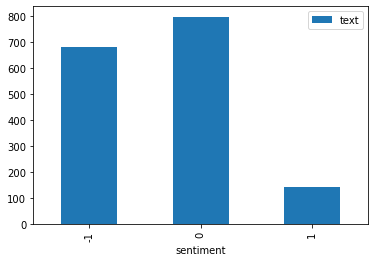

In [6]:
df.groupby('sentiment').count().plot(kind='bar')
plt.savefig('charts/sentiment', bbox_inches='tight')

## Text Processing

In [7]:

# preprocessing  

def remove_pattern(df):
    """This function removes the user handle, URL, emojicons"""
    
    df['tidy_tweet'] = df['text'].str.replace(r'@[\w]*', '')
    df['tidy_tweet'] = df['tidy_tweet'].str.replace(r'https?:\/\/.*[\r\n]*', '')    # remove URL
    df['tidy_tweet'] = df['tidy_tweet'].str.replace("[^a-zA-Z#]", " ")  # remove digits
   # df['tidy_tweet'] = " ".join(df['tidy_tweet'].str.split())  # using split() + join()  # remove additional space from string 
    
    
    return df

In [8]:
remove_pattern(df)


,text,sentiment,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,Wow Yall needa step it up RT Music and sna...
1,What Happened To Apple Inc? http://t.co/FJEX...,0,What Happened To Apple Inc
2,Thank u @apple I can now compile all of the pi...,1,Thank u I can now compile all of the pics tha...
3,The oddly uplifting story of the Apple co-foun...,0,The oddly uplifting story of the Apple co foun...
4,@apple can i exchange my iphone for a differen...,0,can i exchange my iphone for a different colo...
...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,Those PICK UP THE SLACK YOU FUCK BOYS
1620,Finally got my iPhone 6 in the mail and it com...,-1,Finally got my iPhone in the mail and it com...
1621,@umo_games @Apple ended up getting a new compu...,0,ended up getting a new computer anyhow work...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,The Year Old #WizKid Who Turned Down Has N...


In [9]:
df['text'][1]

'What Happened To Apple Inc?   http://t.co/FJEXI3oP0U  #aapl #apple @MoneyPress http://t.co/wXKmmTMArW'

In [10]:
df['tidy_tweet'][1]

'What Happened To Apple Inc    '

In [11]:
# if didnt do 3 stem and tokenize -> can use this -> using split() + join() # remove additional space from string 

res = " ".join(df['tidy_tweet'][1].split())
res

#  df['tidy_tweet'] = df['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

'What Happened To Apple Inc'

## Stem and tokenize

In [12]:
from nltk.stem.porter import *

def tokenize_and_stem(df):
    """This function tokenizes the tweets and stems them and then
    joins them back together."""
    tokenized_tweet = df['tidy_tweet'].astype(str).str.split()  # apply(lambda x: x.split()) #.lower().split(' ')
    stemmer = PorterStemmer()
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])
    for i in range(len(tokenized_tweet)):
        tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
    df['tidy_tweet'] = tokenized_tweet
    return df

In [13]:
tokenize_and_stem(df)


,text,sentiment,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1,wow yall needa step it up RT music and snapcha...
1,What Happened To Apple Inc? http://t.co/FJEX...,0,what happen To appl inc
2,Thank u @apple I can now compile all of the pi...,1,thank u I can now compil all of the pic that i...
3,The oddly uplifting story of the Apple co-foun...,0,the oddli uplift stori of the appl co founder ...
4,@apple can i exchange my iphone for a differen...,0,can i exchang my iphon for a differ color lmao...
...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,-1,those pick UP the slack you fuck boy
1620,Finally got my iPhone 6 in the mail and it com...,-1,final got my iphon in the mail and it come out...
1621,@umo_games @Apple ended up getting a new compu...,0,end up get a new comput anyhow work comput her...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,0,the year old #wizkid who turn down ha nab back...


In [14]:
df['tidy_tweet'][0]  

'wow yall needa step it up RT music and snapchat at the same damn time thank you #note'

In [15]:
nltk.download('stopwords')
         
# add 'TSLA' into stopwords  
                                                                    # this
stop_words = ENGLISH_STOP_WORDS#.union(['aapl', 'appl']) 


#ENGLISH_STOP_WORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegoduque/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
corpus = df['tidy_tweet'].fillna(value='')  # taking care Nan

In [17]:
for tweet in df['text'].sample(10).values:
    print(tweet)
    print()

@apple get your shit together with group chats on ios8

hey @apple my 5s keeps glitching :/

Apple: Dec 8 Total Trading Daily Profits 2.78/sh  #aapl #Stockaction #trading #Stocks #MKt 
http://t.co/Le2r9f5crg

@Apple This was NORMAL use-- NO ABUSE! Wrapped it exactly as you instructed me to. This is a fire hazard. You should replace it. #defective

why isnt group facetime a thing @apple wtf

@Apple [#Apple] #Inc. is Catching up on #iPhone6 Supply, #But Still Lagging Demand. (#Monday, 8 #December) http://t.co/9QpCt7zirF

RT @mkschuster: . @apple why is my computer so slow

Thank you @Apple

Final #AAPL #PutCallRatios for Wednesday, December 3, 2014 http://t.co/Lc6B7m7jut

if i buy a 16 gb phone i should have 16 GB'S TO USE @apple



In [18]:
tfidf = TfidfVectorizer(stop_words=stop_words)  # (stop_words='english') 

tweet_word_matrix = tfidf.fit_transform(corpus)

vocab = tfidf.get_feature_names()
vocab


['aapl',
 'aaron',
 'abandon',
 'abck',
 'abe',
 'abil',
 'abl',
 'ableton',
 'abrick',
 'absolut',
 'abus',
 'accent',
 'accept',
 'access',
 'accessori',
 'accid',
 'accident',
 'accord',
 'accus',
 'achil',
 'acid',
 'act',
 'action',
 'activ',
 'actor',
 'actual',
 'ad',
 'adapt',
 'add',
 'addi',
 'addit',
 'address',
 'adjust',
 'admir',
 'admit',
 'adopt',
 'advanc',
 'advertis',
 'af',
 'africa',
 'agai',
 'age',
 'ago',
 'agre',
 'agreement',
 'ahahahah',
 'ahead',
 'ahhhhhhh',
 'aid',
 'ain',
 'aint',
 'air',
 'airdrop',
 'airmil',
 'airmilesshop',
 'airplay',
 'airport',
 'aka',
 'alabama',
 'alarm',
 'album',
 'alex',
 'alibaba',
 'align',
 'alleg',
 'allow',
 'alon',
 'alreadi',
 'alt',
 'altern',
 'alway',
 'amaz',
 'amazingli',
 'amazon',
 'amend',
 'america',
 'amid',
 'amnt',
 'amp',
 'amzn',
 'anal',
 'analysi',
 'analyst',
 'anderson',
 'android',
 'androidauto',
 'anf',
 'anger',
 'angri',
 'ani',
 'anna',
 'announc',
 'annoy',
 'anon',
 'anoth',
 'answer',
 'anti',

# Topic Modeling - NMF

In [19]:
nmf = NMF(n_components=9)   #15 --> 10 --> 5 --> 3 --> 2

nmf.fit(tweet_word_matrix)  # tweet_word_matrix = tfidf.fit_transform(corpus)

NMF(n_components=9)

In [20]:
tweet_topic_matrix = nmf.transform(tweet_word_matrix)


In [21]:
tweet_topic_matrix_df = pd.DataFrame(tweet_topic_matrix).add_prefix('topic_')

#tweet_topic_matrix_df[['text', 'tidy_tweet']] = df[['text', 'tidy_tweet']]
tweet_topic_matrix_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0.000816,0.003959,0.000000,0.000000,0.084100,0.000469,0.127384,0.019049,0.006416
1,0.044266,0.000474,0.021767,0.015824,0.000000,0.077728,0.000000,0.050801,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166881,0.000000,0.000000
3,0.105676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006284,0.000000
4,0.000000,0.000000,0.000000,0.090628,0.000000,0.000000,0.001649,0.000000,0.005053
...,...,...,...,...,...,...,...,...,...
1619,0.000000,0.125800,0.000000,0.002397,0.000000,0.000000,0.000000,0.000000,0.000000
1620,0.000000,0.000000,0.000000,0.106613,0.000000,0.000000,0.141078,0.000000,0.000000
1621,0.000000,0.000000,0.017376,0.022843,0.006824,0.000000,0.018143,0.025474,0.000000
1622,0.000879,0.000293,0.004596,0.008629,0.007013,0.000000,0.006132,0.003449,0.000896


In [22]:
tweets_df = df[['text', 'tidy_tweet']]
tweets_df

,text,tidy_tweet
0,Wow. Yall needa step it up @Apple RT @heynyla:...,wow yall needa step it up RT music and snapcha...
1,What Happened To Apple Inc? http://t.co/FJEX...,what happen To appl inc
2,Thank u @apple I can now compile all of the pi...,thank u I can now compil all of the pic that i...
3,The oddly uplifting story of the Apple co-foun...,the oddli uplift stori of the appl co founder ...
4,@apple can i exchange my iphone for a differen...,can i exchang my iphon for a differ color lmao...
...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,those pick UP the slack you fuck boy
1620,Finally got my iPhone 6 in the mail and it com...,final got my iphon in the mail and it come out...
1621,@umo_games @Apple ended up getting a new compu...,end up get a new comput anyhow work comput her...
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,the year old #wizkid who turn down ha nab back...


In [23]:
tweet_topic_matrix_all_df = pd.merge(tweet_topic_matrix_df, tweets_df, on = tweet_topic_matrix_df.index)
tweet_topic_matrix_all_df.head()

,key_0,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,text,tidy_tweet
0,0,0.000816,0.003959,0.000000,0.000000,0.0841,0.000469,0.127384,0.019049,0.006416,Wow. Yall needa step it up @Apple RT @heynyla:...,wow yall needa step it up RT music and snapcha...
1,1,0.044266,0.000474,0.021767,0.015824,0.0000,0.077728,0.000000,0.050801,0.000000,What Happened To Apple Inc? http://t.co/FJEX...,what happen To appl inc
2,2,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.166881,0.000000,0.000000,Thank u @apple I can now compile all of the pi...,thank u I can now compil all of the pic that i...
3,3,0.105676,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.006284,0.000000,The oddly uplifting story of the Apple co-foun...,the oddli uplift stori of the appl co founder ...
4,4,0.000000,0.000000,0.000000,0.090628,0.0000,0.000000,0.001649,0.000000,0.005053,@apple can i exchange my iphone for a differen...,can i exchang my iphon for a differ color lmao...


In [24]:
nmf.components_ 


array([[2.32926972e+00, 0.00000000e+00, 6.82195112e-03, ...,
        0.00000000e+00, 4.06185198e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.36851759e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 2.07765447e-04, ...,
        0.00000000e+00, 2.50641063e-03, 0.00000000e+00],
       [0.00000000e+00, 1.51752859e-02, 0.00000000e+00, ...,
        5.73038453e-03, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.43187717e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [25]:
word_topic_matrix_df = pd.DataFrame(nmf.components_ , columns = vocab).T.add_prefix('topic_')
word_topic_matrix_df

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
aapl,2.329270,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
aaron,0.000000,0.0,0.000000,0.000000,0.0,0.000893,0.000000,0.015175,0.000000
abandon,0.006822,0.0,0.000437,0.000000,0.0,0.000000,0.000208,0.000000,0.000343
abck,0.000216,0.0,0.000209,0.000325,0.0,0.000000,0.000667,0.000000,0.000644
abe,0.010497,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
zero,0.000920,0.0,0.000000,0.000000,0.0,0.002810,0.021921,0.000823,0.000000
zoonova,0.001803,0.0,0.000000,0.000000,0.0,0.003805,0.000000,0.000000,0.000000
zu,0.000000,0.0,0.000000,0.019135,0.0,0.000138,0.000000,0.005730,0.000000
zuckerberg,0.040619,0.0,0.000000,0.000000,0.0,0.000000,0.002506,0.000000,0.000000


### Topic Interpretation¶

## topic_0

In [26]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_0', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

What to expect from Apple in 2015 $AAPL #aapl
http://t.co/7Dq9vBdt3H

#AAPL:Apple Inc. (AAPL): Is The Run Over?...http://t.co/Tv2iXZ2r92

Five Apple predictions for 2015 $AAPL #aapl
http://t.co/5y58wpQ3nf

Could Apple Inc. Sell 24 Million Apple Watches in 2015? $AAPL #aapl
http://t.co/DK99Rq2U1e

Who's Buying All Those New iPhones Anyway? $AAPL #aapl
http://t.co/oErygGHnsc



In [27]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
aapl,2.329270,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
appl,1.165325,0.043136,0.022020,0.292239,0.000000,0.738220,0.004598,0.188262,0.000000
price,0.267094,0.000000,0.000507,0.000072,0.000000,0.005194,0.001164,0.000000,0.007692
updat,0.201313,0.032289,0.065172,0.000000,0.026897,0.000000,0.080630,0.000000,0.050535
technic,0.185121,0.000000,0.000000,0.000000,0.063548,0.000000,0.000000,0.000000,0.000000
intraday,0.170698,0.000000,0.000000,0.000000,0.067407,0.000000,0.000000,0.000000,0.000000
fibonacci,0.167618,0.000000,0.000000,0.000000,0.069125,0.000000,0.000000,0.000000,0.000000
buy,0.165443,0.012031,0.048981,0.000000,0.000000,0.088317,0.000000,0.000000,0.000000
level,0.158207,0.000000,0.000000,0.000000,0.089066,0.000000,0.000000,0.000000,0.000000
target,0.141063,0.000000,0.000000,0.000000,0.014889,0.000000,0.000000,0.000000,0.000000


- topic_0: STOCK - AAPL stock price, investing ideas and techinques

### topic_1

In [72]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_1', ascending=False).head(15)['text'].values:
    print(tweet)
    print()

fuck you @apple

fuck you @apple @iphone

more* fuck you @iphone @apple

fuck u @apple

@apple fuck you

@Tyniaaaa_  FUCK @JColeNC  and @apple

FUCK @apple

Fuck you @apple

FUCK YOU @Apple

fuck you too @apple

fuck you fuck you so much i hate you @apple

@HeadxCreeps @Apple fuck you apple

RT @Shuevey: Fuck you @apple

FUCK MY FUCKING PHONE ITS FUCKING TRIPPING IM FUCKING TIRED OF THIS FUCKING BULLSHIT 

IM HOLDING YOU RESPONSIBLE @apple

I hate my MacBook now. Fuck this update and fuck you @apple



In [29]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
fuck,0.000000,2.244405,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
hate,0.037145,0.132373,0.156357,0.000000,0.000000,0.008184,0.000000,0.000000,0.110193
hey,0.000000,0.098906,0.173561,0.015272,0.052312,0.000000,0.000000,0.000000,0.000000
im,0.000000,0.089058,0.044292,0.000000,0.000000,0.000000,0.000000,0.000000,0.051050
actual,0.000000,0.072788,0.015398,0.000000,0.019796,0.000000,0.017075,0.015424,0.000000
phone,0.000000,0.071557,1.076056,0.000000,0.000000,0.000000,0.035477,0.000000,0.028331
delet,0.000000,0.066784,0.031599,0.000000,0.058922,0.000000,0.007360,0.308023,0.000000
faggot,0.000000,0.061393,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
freez,0.000000,0.056421,0.075492,0.000000,0.029074,0.000000,0.000000,0.000000,0.000000
god,0.000000,0.051503,0.006438,0.000000,0.018024,0.012005,0.045676,0.000000,0.010326


- topic_1: Negative_Sentiment - f*** and hate

### topic_2

In [30]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_2', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

This is why I moved over to @Apple... http://t.co/fAW3zsfzt7

@Shagale @apple why'd you do this to us?!

Why are your phone chargers so terrible @apple Fix this @Jesus

My phone died at 8%, why would you let this happen @apple?

RT @QueenCleo_92: Why are your phone chargers so terrible @apple Fix this @Jesus



In [31]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
thi,0.000000,0.000000,1.274012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
phone,0.000000,0.071557,1.076056,0.000000,0.000000,0.000000,0.035477,0.000000,0.028331
whi,0.087838,0.000000,0.840447,0.000000,0.054502,0.000000,0.000000,0.000000,0.000000
fix,0.000000,0.000000,0.460416,0.000000,0.000000,0.000000,0.000000,0.000000,0.241298
die,0.000000,0.007694,0.314601,0.000000,0.078041,0.000000,0.000000,0.000000,0.000000
charger,0.000000,0.000000,0.263998,0.127557,0.257424,0.000000,0.000000,0.000000,0.035118
just,0.000000,0.004878,0.261034,0.066073,0.000000,0.000000,0.085158,0.000000,0.080411
suck,0.000000,0.000000,0.236363,0.000000,0.254936,0.003744,0.000000,0.000000,0.000000
hey,0.000000,0.098906,0.173561,0.015272,0.052312,0.000000,0.000000,0.000000,0.000000
wa,0.003279,0.015862,0.157456,0.000000,0.000000,0.000550,0.094824,0.013268,0.003643


- topic_2: Products: Apple products and technical issues

### topic_3

In [68]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_3', ascending=False).head(5)['text'].values:
    print(tweet)
    print()

#Rumors #Surface for @@Apple [#Apple] #iPhone6S and #iPhone7 in #2015. (#Wednesday, 3 #December) http://t.co/dC5O4hRKNn

#Rumors #Surface for @Apple [#Apple] #iPhone6S and #iPhone7 in #2015. (#Wednesday, 3 #December) http://t.co/ErwYTy3heX

#IPhone6Plus Review: #A New Dawn For @Apple [#Apple]'s #iPhone. (#Thursday, 4 #December) http://t.co/uD0odP62od

iPhone battery life takes the piss sort it out @apple iphone #iphone #apple http://t.co/6f1QuV2DUt

RT @theiphonews: #IPhone6Plus Review: #A New Dawn For @Apple [#Apple]'s #iPhone. (#Thursday, 4 #December) http://t.co/uD0odP62od



In [33]:
word_topic_matrix_df.sort_values(by='topic_3', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
iphon,0.000000,0.000000,0.000000,1.483074,0.000000,0.000000,0.000000,0.000000,0.000000
decemb,0.000000,0.000000,0.000000,0.504797,0.000000,0.035812,0.000000,0.000000,0.000000
new,0.070033,0.018144,0.038312,0.294653,0.080917,0.000000,0.009490,0.000000,0.000000
plu,0.000000,0.000000,0.000000,0.293468,0.000000,0.000000,0.000000,0.000000,0.000000
appl,1.165325,0.043136,0.022020,0.292239,0.000000,0.738220,0.004598,0.188262,0.000000
rumor,0.000000,0.000000,0.000000,0.221880,0.000000,0.000000,0.000000,0.098869,0.000000
monday,0.009139,0.000000,0.000000,0.152942,0.000000,0.003763,0.000000,0.000000,0.000000
wednesday,0.000000,0.000000,0.000000,0.146587,0.000000,0.000336,0.000000,0.000000,0.000000
app,0.000000,0.000000,0.126527,0.141620,0.009564,0.021986,0.000926,0.000000,0.004118
thursday,0.000000,0.000000,0.000000,0.128890,0.000000,0.000000,0.000000,0.000000,0.000000


- topic_3: Apple_Event - rumors, on new devices, new iPhone 

### topic_4

In [69]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_4', ascending=False).head(10)['text'].values:
    print(tweet)
    print()

RT @Shuevey: Fuck you @apple

RT @bchmura12: .@apple you suck

RT @TypicaIStoner: RT if you think @Apple should approve this Emoji http://t.co/MI6sKtkaye

RT @_iamGambino: Thank you @Apple

RT @keelzy: I HAVE BEEN THROUGH ABOUT 18 IPHONE 5 CHARGERS @apple @stevejobs @WTF @!!!!!!!!!!!! @notcool

RT @dmcgroarty: RT @MetalBanker - Where do #iPhones come from? What's in your @Apple  #RareEarths http://t.co/KuMCbKMREV

RT @WillliamLemar: RT @JustPoetic_: Why the fuck is there a 'recently deleted' photo album? @Apple

All of my apple product chargers look like that RT @LunchGod: Theyre not RT @Naivana_: You gotta be kidding me @apple http://t.co/4lXkHinwd2

RT @ProzacNation_: 11am and 20% battery. Die, @apple

RT @KirkYuhnke: What do you think? Want an @Apple #Watch? http://t.co/7HjDjQ1iAb



In [35]:
word_topic_matrix_df.sort_values(by='topic_4', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
rt,0.000000,0.000000,0.000000,0.000000,1.888885,0.000000,0.000000,0.00000,0.000000
charger,0.000000,0.000000,0.263998,0.127557,0.257424,0.000000,0.000000,0.00000,0.035118
suck,0.000000,0.000000,0.236363,0.000000,0.254936,0.003744,0.000000,0.00000,0.000000
think,0.000000,0.018116,0.044472,0.000000,0.199159,0.008892,0.038473,0.00000,0.000000
macbook,0.002122,0.029354,0.000000,0.000000,0.128318,0.063071,0.000000,0.00000,0.009476
emoji,0.000000,0.000000,0.053526,0.000000,0.119132,0.000000,0.000000,0.00000,0.000680
touch,0.000000,0.000000,0.000000,0.000000,0.104835,0.000000,0.000000,0.02205,0.000000
level,0.158207,0.000000,0.000000,0.000000,0.089066,0.000000,0.000000,0.00000,0.000000
watch,0.107422,0.000000,0.004303,0.128083,0.082866,0.003586,0.000000,0.00000,0.000000
new,0.070033,0.018144,0.038312,0.294653,0.080917,0.000000,0.009490,0.00000,0.000000


- topic_4: Chargers - related to iPhone and macbook charger bad quality

### topic_5

In [36]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_5', ascending=False).head(15)['text'].values:
    print(tweet)
    print()

Is Apple The Most Important Stock On Earth?  http://t.co/s5ple0Orww #aapl http://t.co/ZvW4vwZzww

Is Apple The Most Important Stock On Earth?  http://t.co/YkyiwKnL5S #aapl http://t.co/eiAOHl8LL1

Is Apple The Most Important Stock On Earth?  http://t.co/1X62rp5R8y #aapl http://t.co/3YtD8Iz62i

Is Apple The Most Important Stock On Earth?  http://t.co/I5DCA8DagG #aapl http://t.co/Qk9EPOOmhl

Is Apple The Most Important Stock On Earth? http://t.co/gXoZJYZdNy #AAPL

Is Apple The Most Important Stock On Earth?  http://t.co/pKWn6E56PU #aapl http://t.co/gKVmw9wjVD

Is Apple The Most Important Stock On Earth?  http://t.co/fQ75jYND5P #aapl http://t.co/N0tnOVXLD4

Is Apple The Most Important Stock On Earth?  http://t.co/xylQ5d5JN5 #aapl http://t.co/PwxjC5o8Q8

RT @MissionIR: Is Apple The Most Important Stock On Earth?  http://t.co/s5ple0Orww #aapl http://t.co/ZvW4vwZzww

Is It Time to Buy the Dip in Apple Inc. Stock? http://t.co/yDiX7wZOLP #AAPL

Apple ! @apple http://t.co/tCfTmuauMY

Morgan Stan

In [37]:
word_topic_matrix_df.sort_values(by='topic_5', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
stock,0.006874,0.000000,0.000000,0.000000,0.000000,0.921572,0.000000,0.000000,0.000000
import,0.000000,0.000000,0.000000,0.000000,0.000000,0.857019,0.000000,0.000000,0.000000
earth,0.000000,0.000000,0.000000,0.000000,0.000000,0.856972,0.000000,0.000000,0.000000
appl,1.165325,0.043136,0.022020,0.292239,0.000000,0.738220,0.004598,0.188262,0.000000
profit,0.108550,0.000000,0.000000,0.000000,0.000000,0.104088,0.000000,0.000000,0.000000
trade,0.062320,0.000000,0.003506,0.000000,0.000000,0.101136,0.000000,0.000000,0.006534
buy,0.165443,0.012031,0.048981,0.000000,0.000000,0.088317,0.000000,0.000000,0.000000
sh,0.015084,0.000000,0.000000,0.000000,0.000000,0.085193,0.000000,0.000000,0.000000
tech,0.110956,0.000000,0.002976,0.000000,0.043681,0.079917,0.000000,0.000000,0.000000
sell,0.138903,0.000000,0.000000,0.000000,0.000000,0.068286,0.000000,0.000000,0.000000


- topic_5: STOCK and trade - AAPL stock, and Apple's global trade

### topic_6

In [70]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_6', ascending=False).head(15)['text'].values:
    print(tweet)
    print()

Thank you @Apple

@ABillaut @VaynerMedia @Apple Thanks so much!

Thank you @apple

@apple thank you http://t.co/wmSinAAuQf

RT @_iamGambino: Thank you @Apple

@apple @iBooks is awesome. Thank You!

Finally updated #iPhone to IOs 8 something, thanks @apple for more shit we don't need. #seriously, thanks a trillion. http://t.co/JK2LnVs4JW

well imessage doesn't work thanks @apple

iMessage isn't working thanks @apple

RT @saxonidubom: @rwang0 @Apple Thanks...thinking of upgrading.

Just used Apple Pay for the first time thanks @apple

thanks @apple for making life complicated

@ok_fatty @apple thanks 4 almost burning my house down

Goodbye graphics problems. Thank you @apple for such great customer service. http://t.co/uvohriZKYE

Goodbye graphics problems. Thank you @apple for such great customer service. http://t.co/XVB8utXOU3



In [39]:
word_topic_matrix_df.sort_values(by='topic_6', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
thank,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.700698,0.000000,0.000000
servic,0.012880,0.007272,0.023649,0.001631,0.000000,0.016414,0.200183,0.051461,0.000000
great,0.025379,0.012548,0.000000,0.046379,0.000000,0.015144,0.177010,0.000000,0.000000
custom,0.000000,0.000000,0.012477,0.000000,0.000000,0.002677,0.150357,0.116836,0.000000
help,0.023719,0.014891,0.034566,0.083142,0.000000,0.000000,0.140837,0.000000,0.000000
work,0.000000,0.004436,0.127077,0.058242,0.000000,0.000000,0.137942,0.119798,0.016715
awesom,0.003597,0.000000,0.023606,0.000000,0.000000,0.000000,0.122863,0.000000,0.000000
imessag,0.000000,0.012861,0.000000,0.000000,0.000000,0.000000,0.120669,0.001151,0.034920
wa,0.003279,0.015862,0.157456,0.000000,0.000000,0.000550,0.094824,0.013268,0.003643
today,0.000000,0.000000,0.049117,0.025500,0.006058,0.009419,0.092055,0.004412,0.000000


- topic_6: Positive_Sentiment - happy customers

### topic_7

In [71]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_7', ascending=False).head(15)['text'].values:
    print(tweet)
    print()

Steve Wozniak on @Apple, the Computer Revolution, and Working With Steve Jobs http://t.co/01201wlyzu via @BW

@Apple co-founder Steve Wozniak talks about Steve Jobs &amp; Apples early days. via @DesignTaxi http://t.co/JWxSOuTLP7

@Apple #iPod lawsuit will reveal unseen Steve Jobs video http://t.co/nEF5qOGbHE

Steve Job's Deposition in #iPod Lawsuit Could Cost @Apple $1 Billion http://t.co/7vDXwvxKpe #MusicBiz #MusicIndustry #Apple

Steve Wozniak Discusses Apple's Early Days and Working with Steve Jobs [Mac Blog] http://t.co/iPnD6LD5ur #AAPL

RT @smartoutsource1: @Apple #iPod lawsuit will reveal unseen Steve Jobs video http://t.co/nEF5qOGbHE

RT @hypebot: Steve Job's Deposition in #iPod Lawsuit Could Cost @Apple $1 Billion http://t.co/7vDXwvxKpe #MusicBiz #MusicIndustry #Apple

BloombergTV:  Steve #Wozniak on What Really Happened in #Jobs' Garage http://t.co/M5Pl6xLjuV via @BloombergTV #Apple #aapl

Steve Jobs emails featured in Apple iPod US antitrust trial http://t.co/UNEs9ioHtF #AAPL

In [41]:
word_topic_matrix_df.sort_values(by='topic_7', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
steve,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.056930,0.0
job,0.000000,0.000000,0.000000,0.019657,0.000000,0.0,0.000000,0.873315,0.0
ipod,0.016265,0.000000,0.000000,0.000000,0.009547,0.0,0.000000,0.572254,0.0
wozniak,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.411537,0.0
garag,0.000000,0.000000,0.000000,0.050391,0.000000,0.0,0.000000,0.309357,0.0
delet,0.000000,0.066784,0.031599,0.000000,0.058922,0.0,0.007360,0.308023,0.0
lawsuit,0.012825,0.000000,0.000000,0.000000,0.018407,0.0,0.000000,0.272113,0.0
music,0.017956,0.037418,0.008047,0.000000,0.000000,0.0,0.018206,0.260609,0.0
myth,0.000000,0.000000,0.000000,0.059266,0.000000,0.0,0.000000,0.227547,0.0
deposit,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.198630,0.0


- topic_7: Founders - Steve Jobs and Wozniak

### topic_8

In [42]:
for tweet in tweet_topic_matrix_all_df.sort_values(by='topic_8', ascending=False).head(12)['text'].values:
    print(tweet)
    print()

@apple get your shit together.

@Apple get your shit together I hate you

dear @Apple get your shit together

@apple IOS8 is still shit

@apple get cha shit together and fix my phone !!!

@apple get your shit together with group chats on ios8

you just did too much you asshole. @apple get your shit together.

@APPLE YOURE SHIT FIX MY PROBLEM

@apple fuck yo shit

@briannaUrie @Apple Their autocorrect is so shit too

@apple U need to get ur fucking shit together and let me txt while on YouTube

'@WhoaBiebz: GET YOUR SHIT TOGETHER OR I'LL GUY A SAMSUNG GALAXY S5 @APPLE' http://t.co/LEHpmkxK0a



In [43]:
word_topic_matrix_df.sort_values(by='topic_8', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
shit,0.000000,0.021538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.542311
togeth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.818097
need,0.022327,0.000000,0.040439,0.085888,0.026923,0.000000,0.028453,0.062876,0.245272
fix,0.000000,0.000000,0.460416,0.000000,0.000000,0.000000,0.000000,0.000000,0.241298
yo,0.000000,0.026386,0.000000,0.000000,0.000000,0.000000,0.000000,0.000008,0.231112
io,0.009798,0.000000,0.035949,0.069699,0.008277,0.021335,0.019108,0.024191,0.203649
ur,0.000000,0.012849,0.046013,0.000315,0.034106,0.002631,0.000000,0.000000,0.193507
wtf,0.000000,0.000000,0.076309,0.002129,0.000000,0.000000,0.000000,0.000000,0.174430
product,0.003574,0.015025,0.000000,0.049775,0.040256,0.019895,0.017790,0.000000,0.152888
dear,0.000000,0.000000,0.061127,0.000000,0.043753,0.004998,0.002137,0.000000,0.143915


- topic_8: Quality - negative coments again broken products and iOS

### Topic Modeling Conclusions

- topic_0: STOCK - AAPL stock price, investing ideas and techinques
- topic_1: Negative_Sentiment - f*** and hate
- topic_2: Products: Apple products and technical issues
- topic_3: Apple_Event - rumors, on new devices, new iPhone 
- topic_4: Chargers - related to iPhone and macbook charger bad quality
- topic_5: STOCK and trade - AAPL stock, and Apple's global trade
- topic_6: Positive_Sentiment - happy customers
- topic_7: Founders - Steve Jobs and Wozniak
- topic_8: Quality - negative coments again broken products and iOS

## Sentiment analysis

In [47]:
def sentimentScore(df):
    analyzer = SentimentIntensityAnalyzer()
    df['sentiment'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet))
    df['sentiment_compound'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['compound']) 
    # focus on compound
    df['sentiment_pos'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['pos']) 
    df['sentiment_neg'] = df['tidy_tweet'].apply(lambda tweet: analyzer.polarity_scores(tweet)['neg']) 
    
    return df

In [50]:
df

,text,sentiment,tidy_tweet,sentiment_compound,sentiment_pos,sentiment_neg
0,Wow. Yall needa step it up @Apple RT @heynyla:...,"{'neg': 0.113, 'neu': 0.625, 'pos': 0.263, 'co...",wow yall needa step it up RT music and snapcha...,0.5574,0.263,0.113
1,What Happened To Apple Inc? http://t.co/FJEX...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",what happen To appl inc,0.0000,0.000,0.000
2,Thank u @apple I can now compile all of the pi...,"{'neg': 0.0, 'neu': 0.865, 'pos': 0.135, 'comp...",thank u I can now compil all of the pic that i...,0.3612,0.135,0.000
3,The oddly uplifting story of the Apple co-foun...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",the oddli uplift stori of the appl co founder ...,0.0000,0.000,0.000
4,@apple can i exchange my iphone for a differen...,"{'neg': 0.0, 'neu': 0.769, 'pos': 0.231, 'comp...",can i exchang my iphon for a differ color lmao...,0.5994,0.231,0.000
...,...,...,...,...,...,...
1619,Those** PICK UP THE SLACK YOU FUCK BOYS @Apple,"{'neg': 0.333, 'neu': 0.667, 'pos': 0.0, 'comp...",those pick UP the slack you fuck boy,-0.5423,0.000,0.333
1620,Finally got my iPhone 6 in the mail and it com...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",final got my iphon in the mail and it come out...,0.3612,0.122,0.000
1621,@umo_games @Apple ended up getting a new compu...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",end up get a new comput anyhow work comput her...,0.0000,0.000,0.000
1622,The 19-Year-Old #WizKid Who Turned Down @Apple...,"{'neg': 0.0, 'neu': 0.844, 'pos': 0.156, 'comp...",the year old #wizkid who turn down ha nab back...,0.3400,0.156,0.000


### Positive

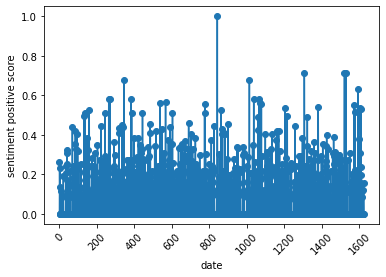

In [73]:
plt.plot(df.index, df.sentiment_pos ,marker='o')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('sentiment positive score')
plt.savefig('charts/positive', bbox_inches='tight')

### Negative

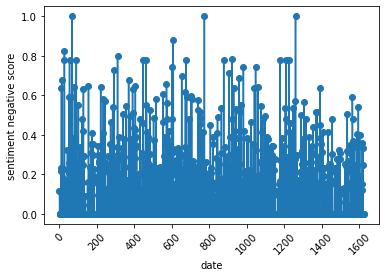

In [74]:
plt.plot(df.index, df.sentiment_neg ,marker='o')
plt.xticks(rotation = 45)
plt.xlabel('date')
plt.ylabel('sentiment negative score')
plt.savefig('charts/negative', bbox_inches='tight')

## K-means clustering (Unsupervised Learning)

on tweet-topic-matrix df
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
Methods

fit_predict(X[, y, sample_weight])
Compute cluster centers and predict cluster index for each sample.

fit_transform(X[, y, sample_weight])
Compute clustering and transform X to cluster-distance space.

In [55]:
tweet_topic_matrix_df


,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8
0,0.000816,0.003959,0.000000,0.000000,0.084100,0.000469,0.127384,0.019049,0.006416
1,0.044266,0.000474,0.021767,0.015824,0.000000,0.077728,0.000000,0.050801,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166881,0.000000,0.000000
3,0.105676,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006284,0.000000
4,0.000000,0.000000,0.000000,0.090628,0.000000,0.000000,0.001649,0.000000,0.005053
...,...,...,...,...,...,...,...,...,...
1619,0.000000,0.125800,0.000000,0.002397,0.000000,0.000000,0.000000,0.000000,0.000000
1620,0.000000,0.000000,0.000000,0.106613,0.000000,0.000000,0.141078,0.000000,0.000000
1621,0.000000,0.000000,0.017376,0.022843,0.006824,0.000000,0.018143,0.025474,0.000000
1622,0.000879,0.000293,0.004596,0.008629,0.007013,0.000000,0.006132,0.003449,0.000896


In [56]:
X =  tweet_topic_matrix

use elbow method to find the best K

In [57]:
wcss = []

for i in range(1, 25):
    kmeans = KMeans(n_clusters = i, init='k-means++', random_state= 0)  # max_iter=1000, n_init = 100, random_state=1234) #
    kmeans.fit(X)   
    wcss.append(kmeans.inertia_)

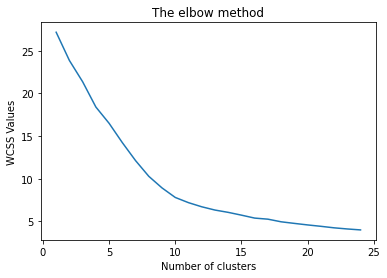

In [58]:
plt.plot(range(1,25), wcss)  
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS Values')
plt.show()                     

### Create KMeans model

In [59]:
# model 1
kmeansmodel = KMeans(n_clusters = 9 , init='k-means++', random_state=1234) # max_iter: default=300, #n_init: default=10
kmeansmodel.fit(X)
kmeansmodel.labels_

array([3, 1, 3, ..., 1, 1, 0], dtype=int32)

In [60]:
kmeans_clust = kmeansmodel.fit_predict(X)

### TruncatedSVD and plot

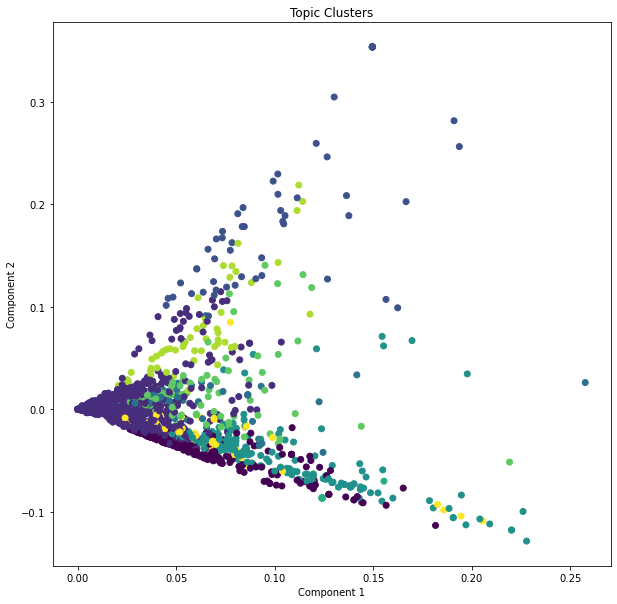

In [65]:
# Build SVD model  -> make plot
svd_model = TruncatedSVD(n_components=2)  # 2 components
nmf_1_svd = svd_model.fit_transform(X)


# plot axes using SVD decomposition
x_val = nmf_1_svd[:, 0]
y_val = nmf_1_svd[:, 1]

# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.savefig('charts/svd', bbox_inches='tight')

9 clusters(kmeans) is not equals to 9 topics (nmf).

Clustering is like doing a topic modeling on topics.

Each cluster can have different percentage of topics, for example:

- Cluster 1 has 10 % of topic 1 and 90 % of topic 2
- Cluster 2 has 5 % of topic 1 and 70 % of topic 3 and 25% of topic 5

### TSNE for Clustering ploting

use TSNE replace SVD

since our problem has higher dimensions so TSNE can help https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

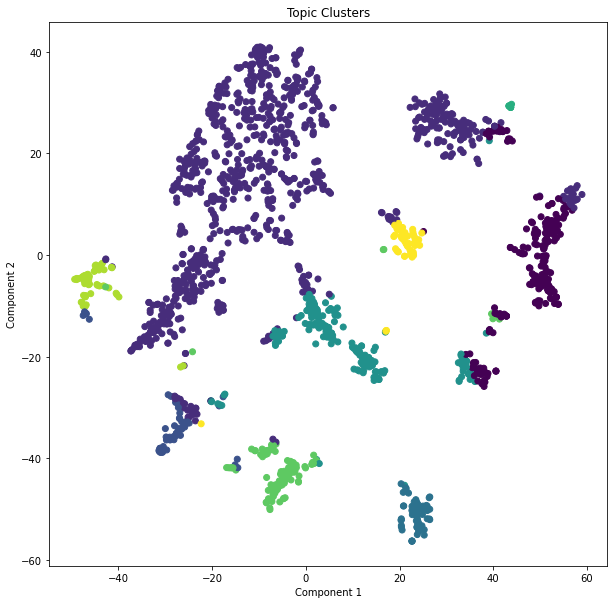

In [66]:
tsne = TSNE(n_components=2) 
nmf_1_tsne = tsne.fit_transform(X)

#print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

# plot axes using TSNE decomposition
x_val = nmf_1_tsne[:, 0]
y_val =nmf_1_tsne[:, 1]

# Plot the cluster of points by topics

plt.figure(figsize=(10, 10))
plt.scatter(x_val, y_val, c=kmeans_clust)
plt.ylabel('Component 2')
plt.xlabel('Component 1')
plt.title("Topic Clusters")
plt.savefig('charts/TSNE', bbox_inches='tight')